# Tutorial 5: Classification and clustering analysis

---

### Introduction

In this notebook, we will examine the galaxy data in two different ways:
   1. *Clustering*: Clustering uses unsupervised learning (with unlabeled data) to group together similar images. Note however that the groups may not correspond to the actual classes that we're interested in.
   2. *Classifcation*: classification uses supervised learning (with labeled data) to develop an algorithm for determining the class of new images.
   

We begin with the usual imports.

In [27]:
import numpy as np
import pandas as pd
# For evaluating classification accuracy
from sklearn.metrics import precision_recall_fscore_support

In [28]:
import matplotlib.pyplot as plt # for plotting data/graphs
import numpy as np # For handling N-DIMENSIONAL ARRAYS

import tensorflow as tf #An end-to-end machine learning platform, focusing on training deep learning models
from tensorflow.keras import layers, losses # Implementation of the Keras API, the high-level API of TensorFlow.
from tensorflow.keras.models import Model #This displays graphs
import torchvision.transforms as transforms #Transforms are for common image transformations
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plotting
import scipy.stats as st

### Reading in data
The following code is the same as in Tutorial 1.

In [29]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

### Downloading data

First, let us call the python script that will let us download the data.

In [30]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()




Next let's recall the data. This tutorial will use the extracted features from the shallow autoencoder model (2nd notebook).

In [31]:
# Preprocessed input data for train and test
import pickle
with open('./auto_df_train.pkl','rb') as file:
  auto_df_train = pickle.load(file)
with open('./auto_df_test.pkl','rb') as file1:
  auto_df_test = pickle.load(file1)
with open('./labels_train.pkl','rb') as file2:
  labels_train = pickle.load(file2)
with open('./labels_test.pkl','rb') as file3:
  labels_test = pickle.load(file3)
with open('./classes.pkl','rb') as file4:
  classes = pickle.load(file4)

Next let's load the data. Remember that this data has already been preprocessed using the shallow encoder (see Tutorial 2).  For clustering we don't need the labeled data, but we'll need it later for classification.

---

### Clustering

We will use `kmeans` for clustering the galaxy images. `kmeans` is a popular unsupervised learning method. Other unsupervised learning methods can be found [here](https://scikit-learn.org/stable/modules/clustering.html).

In [33]:
from sklearn.cluster import KMeans

In [34]:
kmeans = KMeans(init="k-means++", n_clusters=3)
kmeans.fit(auto_df_train)
# 'pred_cluster' is a 1-d array that gives the cluster assigned to each data point (0,1, or 2)
pred_cluster = kmeans.predict(auto_df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Now let's see if the clustering agrees with the actual galaxy labels. The function `plot_confusion_matrix` (in the `source` directory) graphically represents the accuracy using a *confusion matrix*. The rows of the confusion matrix correspond to the actual classes, while the columns correspond to the different clusters with their assigned labels.  

In [35]:
#from clustering import plot_confusion_matrix
from scipy.optimize import linear_sum_assignment as linear_assignment
import numpy as np
import matplotlib.pyplot as plt # for plotting§
from sklearn import metrics
###

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def labelMap(vol, pred):
    cm = metrics.confusion_matrix(vol, pred)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.asarray(indexes)
    return indexes[1]

def convertLabels(lmap, pred):
    conv_preds = []
    for i in range(len(pred)):
        conv_preds.append(lmap[pred[i]])
    return np.array(conv_preds)

def plot_confusion_matrix(predictions, input_data, input_labels, classes):

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1, 2])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm)

    plt.title('Confusion matrix', y=1.08)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(classes)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()




The question is, which cluster should correspond to which label?  Initially, we simply assign clusters 0,1,2 to labels 0,1,2. (This is just a random choice--there's no reason to suppose it's going to be the best assignment).

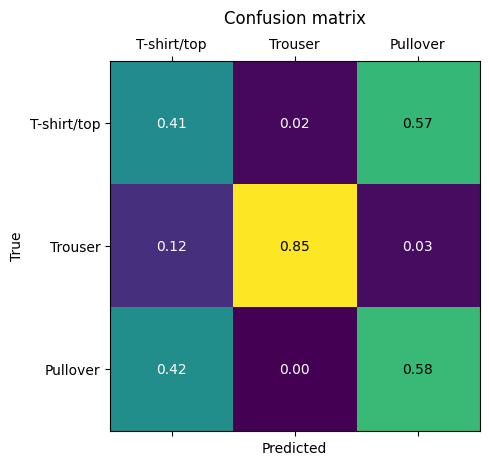

In [36]:
plot_confusion_matrix(pred_cluster, auto_df_test, labels_test, classes)

The confusion matrix shows that clustering does not do a very good job of distinguishing the actual classes. For example, 42\% of Pullover are located in the cluster that is assigned to T-shirt/top. Also, only 58\% of the actual 'Trouser' galaxies are correctly identified by the cluster assigned by the algorithm.

To get the precision, recall, and f-score  for the above classification, we may use the function from `scikit-learn`:

In [37]:
print(precision_recall_fscore_support(y_pred=pred_cluster, y_true=labels_test, average='weighted'))

(0.6335826801045166, 0.6143333333333333, 0.6213573828470379, None)


The f-score is only 0.62, Let's try to improve this.  The function `labelMap` (in the `source` directory) finds the assignment of clusters to labels that maximizes accuracy.

(For another example (using different data) where clusters are optimally assigned to actual labels, see the following [reference](https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/).)

In [38]:
#from clustering import labelMap, convertLabels
from scipy.optimize import linear_sum_assignment as linear_assignment
import numpy as np
import matplotlib.pyplot as plt # for plotting§
from sklearn import metrics
###

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def labelMap(vol, pred):
    cm = metrics.confusion_matrix(vol, pred)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.asarray(indexes)
    return indexes[1]

def convertLabels(lmap, pred):
    conv_preds = []
    for i in range(len(pred)):
        conv_preds.append(lmap[pred[i]])
    return np.array(conv_preds)

def plot_confusion_matrix(predictions, input_data, input_labels, classes):

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1, 2])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm)

    plt.title('Confusion matrix', y=1.08)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(classes)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

In [39]:
lmap = labelMap(np.array(labels_test), pred_cluster)
print(lmap)
# Reorder the cluster labels according to the results of lmap
conv_preds_cluster = lmap[pred_cluster]

[2 1 0]


Let's replot the confusion matrix with the new cluster assignment:

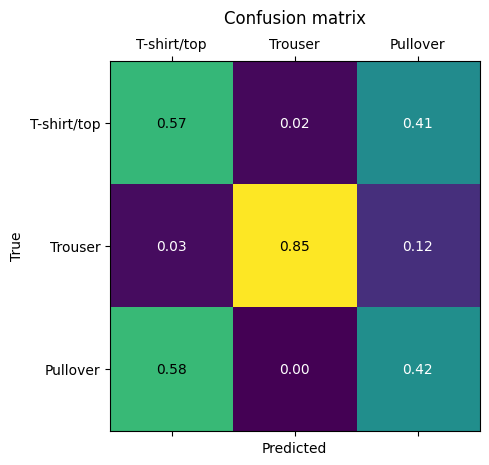

In [40]:
plot_confusion_matrix(conv_preds_cluster, auto_df_test, labels_test, classes)

In [41]:
print(precision_recall_fscore_support(y_pred=conv_preds_cluster, y_true=labels_test, average='weighted'))

(0.6345382605449795, 0.6146666666666667, 0.6220175655761863, None)


Even with an optimzed cluster assignment, the f-score is only 0.62. Simple clustering is not sufficient to distinguish between the classes we're interested in.  So let's try supervised learning instead.

---

**Exercise :** from [this list](https://scikit-learn.org/stable/modules/clustering.html)
choose another clustering method and report the results

In [42]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=3)
agglomerative.fit(auto_df_train)
# 'pred_cluster' is a 1-d array that gives the cluster assigned to each data point (0,1, or 2)
pred_clusteragglo  = agglomerative.fit_predict(auto_df_test)


In [43]:
#from clustering import plot_confusion_matrix
from scipy.optimize import linear_sum_assignment as linear_assignment
import numpy as np
import matplotlib.pyplot as plt # for plotting§
from sklearn import metrics
###

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def labelMap(vol, pred):
    cm = metrics.confusion_matrix(vol, pred)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.asarray(indexes)
    return indexes[1]

def convertLabels(lmap, pred):
    conv_preds = []
    for i in range(len(pred)):
        conv_preds.append(lmap[pred[i]])
    return np.array(conv_preds)

def plot_confusion_matrix(predictions, input_data, input_labels, classes):

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1, 2])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm)

    plt.title('Confusion matrix', y=1.08)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(classes)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()



The question is, which cluster should correspond to which label?  Initially, we simply assign clusters 0,1,2 to labels 0,1,2. (This is just a random choice--there's no reason to suppose it's going to be the best assignment).

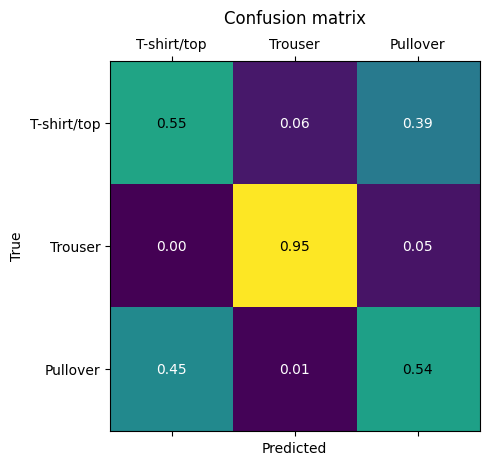

In [44]:
plot_confusion_matrix(pred_clusteragglo, auto_df_test, labels_test, classes)

The confusion matrix shows that clustering does not do a very good job of distinguishing the actual classes. For example, 45\% of Pullover are located in the cluster that is assigned to T-shirt/top. Also, only 54\% of the actual 'Trouser' galaxies are correctly identified by the cluster assigned by the algorithm.

To get the precision, recall, and f-score  for the above classification, we may use the function from `scikit-learn`:

In [45]:
print(precision_recall_fscore_support(y_pred=pred_clusteragglo, y_true=labels_test, average='weighted'))

(0.6793940216544644, 0.6816666666666666, 0.6804795323694233, None)


The f-score is only 0.6804, Let's try to improve this.  The function `labelMap` (in the `source` directory) finds the assignment of clusters to labels that maximizes accuracy.

(For another example (using different data) where clusters are optimally assigned to actual labels, see the following [reference](https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/).)

In [46]:
#from clustering import labelMap, convertLabels
from scipy.optimize import linear_sum_assignment as linear_assignment
import numpy as np
import matplotlib.pyplot as plt # for plotting§
from sklearn import metrics
###

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def labelMap(vol, pred):
    cm = metrics.confusion_matrix(vol, pred)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.asarray(indexes)
    return indexes[1]

def convertLabels(lmap, pred):
    conv_preds = []
    for i in range(len(pred)):
        conv_preds.append(lmap[pred[i]])
    return np.array(conv_preds)

def plot_confusion_matrix(predictions, input_data, input_labels, classes):

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1, 2])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm)

    plt.title('Confusion matrix', y=1.08)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(classes)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

In [47]:
lmapagglo = labelMap(np.array(labels_test), pred_clusteragglo)
print(lmap)
# Reorder the cluster labels according to the results of lmap
conv_preds_clusteragglo = lmapagglo[pred_clusteragglo]

[2 1 0]


Let's replot the confusion matrix with the new cluster assignment:

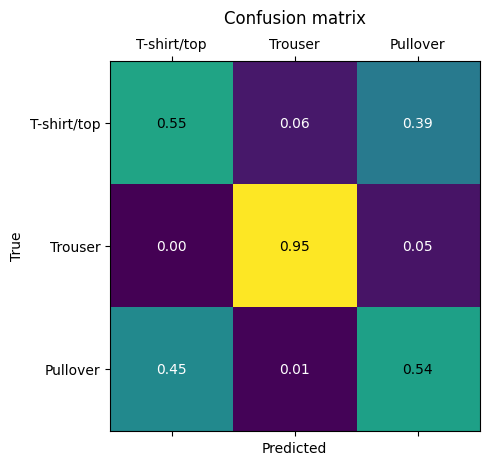

In [48]:
plot_confusion_matrix(conv_preds_clusteragglo, auto_df_test, labels_test, classes)

In [49]:
print(precision_recall_fscore_support(y_pred=conv_preds_clusteragglo, y_true=labels_test, average='weighted'))

(0.6793940216544644, 0.6816666666666666, 0.6804795323694233, None)


Even with an optimzed cluster assignment, the f-score is only 0.68. Simple clustering is not sufficient to distinguish between the classes we're interested in.  So let's try supervised learning instead.

---

### Supervised learning

The `scikit-learn`package implements many different  methods for classification using supervised learning. Here we'll try *stochastic gradient descent* (SDG).  You may try others, to see if you can get a better result. They all follow pretty much the same procedure.

In [50]:
from sklearn.linear_model import SGDClassifier

In [51]:
sgd = SGDClassifier()

sgd.fit(auto_df_train, labels_train)

SGDClassifier()

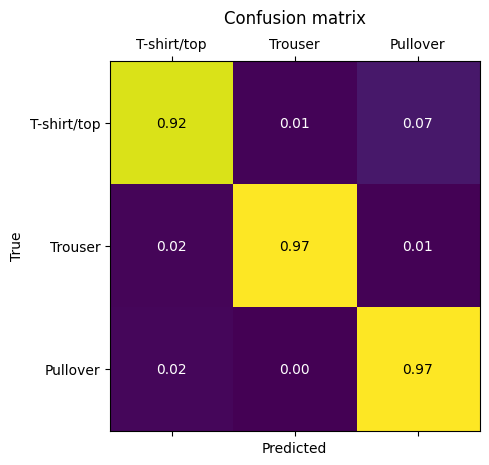

In [52]:
y_predict = sgd.predict(auto_df_test)

plot_confusion_matrix(y_predict, auto_df_test, labels_test, classes)


In [53]:
print(precision_recall_fscore_support(y_pred=y_predict, y_true=labels_test, average='weighted'))

(0.9566600418235568, 0.956, 0.9559684347272183, None)


We do get slightly better results than the unsupervised learning. But it seems very difficult to distinguish between smooth round, smooth cigar and edge on disk.

**Exercise :** Use Google and try to search other supervise learning tools and try them out, and show the results

###**We choose logistic regression. It is implemented in LogisticRegression. Despite its name, it is implemented as a linear model for classification rather than regression in terms of the scikit-learn/ML nomenclature.**

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
model = LogisticRegression(max_iter=1000)

model.fit(auto_df_train, labels_train)

LogisticRegression(max_iter=1000)

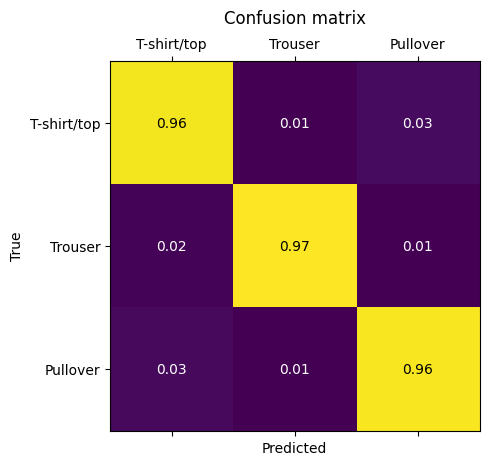

In [56]:
y_predict = model.predict(auto_df_test)

plot_confusion_matrix(y_predict, auto_df_test, labels_test, classes)


In [57]:
print(precision_recall_fscore_support(y_pred=y_predict, y_true=labels_test, average='weighted'))

(0.963109345443186, 0.963, 0.9630398783826283, None)


We do get slightly better results than the unsupervised learning. But it seems very difficult to distinguish between smooth round, smooth cigar and edge on disk.

---

**Notice :** For both the clustering and the classification approach, instead of the shallow autoencoder you can try other methods like manual feature engineering and/or feature reduction from PCA.

---

#### Final task

Now the fun starts. How about if we get a totally new data set and try some of the tools that we have learned from the past few tutorials. You can go and explore data in any subject area, as long as it's image data. The data doesn't have to be labeled, as we already taught you how to do unsupervised learning (clustering). it also has to have fewer  than 10,000 images for the pipeline to run in a reasonable amount of time. Please  approach an instructor if you need some advice.

here are some links that we can use to donwload new data sets:
1. https://www.kaggle.com/datasets
2. https://github.com/awesomedata/awesome-public-datasets